In [1]:
import json
import numpy as np
import pandas as pd

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

from scipy import spatial

# Devils DFTD Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

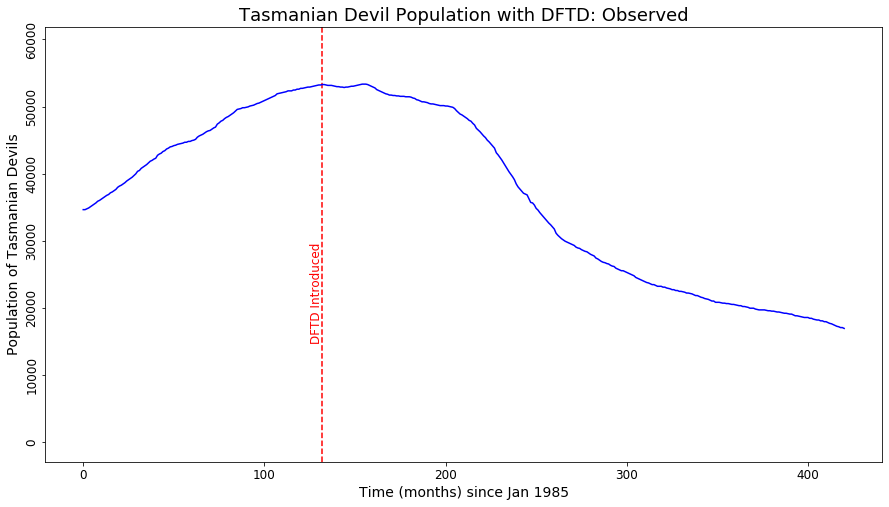

In [3]:
plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population with DFTD: Observed", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.16], '--r')
plt.ylim([-3000, max(devil_pop)*1.16])
plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
_ = plt.plot(range(len(devil_pop)), devil_pop, 'b', label='Observed Total')

## Model

In [453]:
variables = {
    "juvenile_concentration": 0.3,
    "infected_concentration": 2.8888e-05,
    "birth_rate": 0.055, #0.027  #1st order birth
    "birth_rate2": 1.275e-6, #2nd order birth
    "death_rate_susceptible": 0.02335,
    "death_rate_susceptible2": 8.25e-7,
    "death_rate_infected": 0.044,
    "latency": 27.39,
    "infection_rate": 0.48,
    "maturity_rate": 0.04167,
    "death_rate_juvenile": 0.0065
}

In [454]:
class DevilsPreVaccination(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils Pre-Vaccination")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        birth_rate2 = Parameter(name="birth_rate2", expression=values['birth_rate2'])
        carrying_capacity = Parameter(name="carrying_capacity", expression=int(max(devil_pop)*1.16))
        print("carrying_capacity={0}".format(carrying_capacity.value))
        death_rate_susceptible = Parameter(name="death_rate_susceptible",expression=values['death_rate_susceptible'])
        death_rate_susceptible2 = Parameter(name="death_rate_susceptible2",expression=values['death_rate_susceptible2'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        latency = Parameter(name="latency", expression=values['latency'])
        infection_rate = Parameter(name="infection_rate", expression=values['infection_rate'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        self.add_parameter([birth_rate, birth_rate2, carrying_capacity, death_rate_susceptible,death_rate_susceptible2, death_rate_juvenile,
                            death_rate_infected, latency, infection_rate, maturity_rate])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", initial_value=round(initial_devil_population*values['juvenile_concentration']), mode="discrete"
        )
        Susceptible = Species(
            name="Susceptible", initial_value=round(initial_devil_population*(1-values['juvenile_concentration'])),
            mode="discrete"
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Devils])

        # Reactions
#         Birth = Reaction(name="Birth",
#             reactants={}, products={'Juvenile': 1, 'Devils': 1},
#             propensity_function="birth_r2ate*(Susceptible + Exposed + Infected)*\
#                                  (1-(Susceptible + Exposed + Infected)/carrying_capacity)"
#         )
#         Transmission = Reaction(name="Transmission",
#             reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
#             propensity_function="infection_rate* Susceptible* Infected/carrying_capacity"
#         )

        Birth1 = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate*(Susceptible+Exposed+Infected)"
        )
        Birth2 = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate2*(Susceptible+Exposed+Infected)*(Susceptible+Exposed+Infected-1)"
        )
        self.add_reaction(Birth1)
        #self.add_reaction(Birth2)
        
    
    
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible* Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible2* Susceptible * (Susceptible-1)"
        )
        
        
        Transmission = Reaction(name="Transmission",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate*Susceptible*Infected"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible*Exposed"
        )
        Latency = Reaction(name="Latency",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed/latency"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected*Infected"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )


        self.add_reaction([Death_Susceptible, Death_Susceptible2, Transmission, Death_Exposed,
                           Latency, Death_Infected, Mature, Death_Juvenile])

                
        # Events
        if events is not None:
            self.add_event(events)
        
        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan        
        #self.timespan(np.linspace(0, 10, 421)) # month data tspan
        

In [455]:
model = DevilsPreVaccination(values = {
    "juvenile_concentration": 0.3,
    "infected_concentration": 2.8888e-05,
    "birth_rate": 0.055, #0.027  #1st order birth
    "birth_rate2": 1.275e-6, #2nd order birth
    "death_rate_susceptible": 0.02335,
    "death_rate_susceptible2": 8.25e-7,
    "death_rate_infected": 0.044,
    "latency": 27.39,
    "infection_rate": 0.48,
    "maturity_rate": 0.04167,
    "death_rate_juvenile": 0.0065
})

carrying_capacity=61874.0


In [456]:
%time result = model.run()

CPU times: user 20.2 ms, sys: 36.6 ms, total: 56.8 ms
Wall time: 4.51 s


In [457]:
result[0]['Devils'][-1]

62611.0

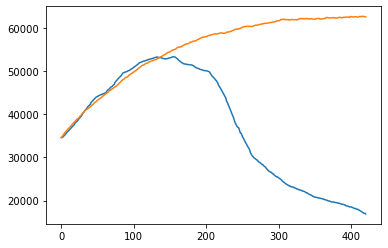

In [458]:
plt.plot(devil_pop)
plt.plot(result[0]['Devils'])

In [459]:
result.plotplotly()

In [88]:
def event_model(run=False):
    trigger = EventTrigger(expression="t >= 132")
    assignments = [
        EventAssignment(
            variable="Infected", expression=f"round(Susceptible * {variables['infected_concentration']})"
        ),
        EventAssignment(
            variable="Susceptible", expression=f"round(Susceptible * 1-{variables['infected_concentration']})"
        )
    ]
    DFTD_Introduction = Event(name="DFTD_Introduction", assignments=assignments, trigger=trigger)
    e_model = DevilsPreVaccination(values=variables, events=[DFTD_Introduction])
    
    if not run:
        return e_model
    
    results = e_model.run()

    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(results['time'], obs[0][0], '--', color='black', label='Observed Total')
    plt.plot(results['time'], results['Devils'], color='blue', label='Simulated Total')
    plt.plot(results['time'], results['Juvenile'], color='purple', alpha=.3, label='Juvenile')
    plt.plot(results['time'], results['Susceptible'], color='green', alpha=.3, label='Susceptible')
    plt.plot(results['time'], results['Infected'], color='red', alpha=.3, label='Infected')
    plt.plot(results['time'], results['Exposed'], color='yellow', alpha=.3, label='Exposed')
    plt.plot([132, 132], [-3000, e_model.listOfParameters['carrying_capacity'].value], '--r')
    plt.ylim([-3000, e_model.listOfParameters['carrying_capacity'].value])
    plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

carrying_capacity=61874.0


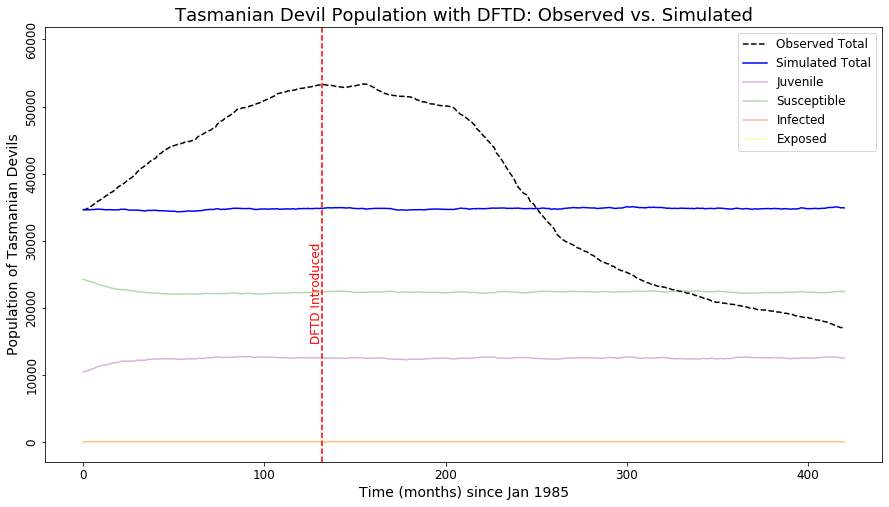

In [89]:
event_model(run=True)

In [90]:
model = DevilsPreVaccination(values=variables)

carrying_capacity=61874.0


In [91]:
solver = SSACSolver(model, variable=True)

## Configure Solver Widgets

In [92]:
def run_pre_infection(start, end):
    variable = {
        "Devils": round(devil_pop[start]),
        "Juvenile": round(devil_pop[start] * variables['juvenile_concentration']),
        "Susceptible": round(devil_pop[start] * (1 - variables['juvenile_concentration'])),
        "birth_rate": variables['birth_rate'],
        "maturity_rate": variables['maturity_rate'],
        "death_rate_juvenile": variables['death_rate_juvenile'],
        "death_rate_susceptible": variables['death_rate_susceptible']
    }
    results = solver.run(model=model, variables=variable, t=end-start)
    total_devils = np.add(
        np.add(results['Juvenile'], results['Susceptible']), np.add(results['Exposed'], results['Infected'])
    )
    ec_result = spatial.distance.euclidean(total_devils, devil_pop[start:end+1])
    mn_result = spatial.distance.cityblock(total_devils, devil_pop[start:end+1])
    return (results, total_devils, ec_result, mn_result)

In [93]:
def run_post_infection(start, end, pre_result, dftd_start):
    if start == (dftd_start + 1):
        kwargs = {"t": end-start+len(pre_result['time']), "resume": pre_result}
        Devils_pop = pre_result['Devils'][-1]
        init_S_pop = pre_result['Susceptible'][-1]
        J_pop = pre_result['Juvenile'][-1]
        S_pop = round(init_S_pop * (1-variables['infected_concentration']))
        I_pop = round(init_S_pop * variables['infected_concentration'])
    else:
        kwargs = {"t": end-start}
        Devils_pop = round(devil_pop[start])
        J_pop = round(devil_pop[start] * variables['juvenile_concentration'])
        init_S_pop = devil_pop[start] - J_pop
        S_pop = round(init_S_pop - J_pop * (1-variables['infected_concentration']))
        I_pop = round(init_S_pop * variables['infected_concentration'])
    print(I_pop)
    variable = {
        "Devils": Devils_pop,
        "Juvenile": J_pop,
        "Susceptible": S_pop,
        "Infected": I_pop,
        "birth_rate": variables['birth_rate'],
        "maturity_rate": variables['maturity_rate'],
        "latency": variables['latency'],
        "infection_rate": variables['infection_rate'],
        "death_rate_juvenile": variables['death_rate_juvenile'],
        "death_rate_susceptible": variables['death_rate_susceptible'],
        "death_rate_infected": variables['death_rate_infected']
    }
    results = solver.run(model=model, variables=variable, **kwargs)
    total_devils = np.add(
        np.add(results['Juvenile'], results['Susceptible']), np.add(results['Exposed'], results['Infected'])
    )
    ec_result = spatial.distance.euclidean(total_devils[:-1], devil_pop)
    mn_result = spatial.distance.cityblock(total_devils[:-1], devil_pop)
    return (results, total_devils, ec_result, mn_result)

In [16]:
def display_details(pre_start, pre_end, post_start, post_end, pre_data, post_data):
    print('='*100)
    # Changes to species concentration values
    print('|', 'Input Species:'.ljust(96), '|')
    print('|', f'\tJuvenile Concentration: {variables["juvenile_concentration"]}'.ljust(91), '|')
    print('|', f'\tInfected Concentration: {variables["infected_concentration"]}'.ljust(91), '|')
    print(f'| {"-"*96} |')
    # Changes to parameters
    print('|', 'Input Parameters:'.ljust(96), '|')
    print('|', f'\tBirth Rate: {variables["birth_rate"]}'.ljust(27), end="")
    print(f'Maturity Rate: {variables["maturity_rate"]}'.ljust(32), end="")
    print(f'Death Rate Juvenile: {variables["death_rate_juvenile"]}'.ljust(32), '|')
    print('|', f'\tLatency: {variables["latency"]}'.ljust(43), end="")
    print(f'Infection Rate: {variables["infection_rate"]}'.ljust(48), '|')
    print('|', f'\tDeath Rate Susceptible: {variables["death_rate_susceptible"]}'.ljust(43), end="")
    print(f'Death Rate Infected: {variables["death_rate_infected"]}'.ljust(48), '|')
    print(f'|{"="*98}|')
    print('|', 'Pre-Infection'.ljust(46), end=' |')
    print('|', 'Post-Infection'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', f'Time Range: {dates[pre_start]} - {dates[pre_end]}'.ljust(46), end=' |')
    print('|', f'Time Range: {dates[post_start]} - {dates[post_end]}'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', f'Initial Value of Devils: {round(devil_pop[pre_start])}'.ljust(46), end=' |')
    print('|', f'Initial Value of Devils: {round(devil_pop[post_start])}'.ljust(46), '|')
    print('|', ' '*46, '||', f'Initial Value of Susceptible: {post_data[0]["Susceptible"][0]}'.ljust(46), '|')
    print('|', ' '*46, '||', f'Initial Value of Infected: {post_data[0]["Infected"][0]}'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', 'Distance Metrics:'.ljust(46), '||', 'Distance Metrics:'.ljust(46), '|')
    print('|', f'      Euclidean: {pre_data[2]}'.ljust(46), end=' |')
    print('|', f'      Euclidean: {post_data[2]}'.ljust(46), '|')
    print('|', f'      Manhattan: {pre_data[3]}'.ljust(46), end=' |')
    print('|', f'      Manhattan: {post_data[3]}'.ljust(46), '|')
    print('|', f'TOTAL Expected: {devil_pop[pre_end-1]} - Got: {pre_data[1][-1]}'.ljust(46), end=' |')
    print('|', f'TOTAL Expected: {devil_pop[post_end-1]} - Got: {post_data[1][-1]}'.ljust(46), '|')
    print('='*100)

In [17]:
def plot(pre_start, pre_end, post_start, post_end, pre_data, post_data, dftd_start):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    ax1.plot(range(pre_start, pre_end), devil_pop[pre_start:pre_end], '--', color='black', label='Observed Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[1], color='blue', label='Simulated Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Juvenile'], color='purple', alpha=.3, label='Juvenile')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Susceptible'], color='green', alpha=.3, label='Susceptible')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Infected'], color='red', alpha=.3, label='Infected')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Exposed'], color='yellow', alpha=.3, label='Exposed')
#     ax1.set_ylim(top=pre_data[0].model.listOfParameters['carrying_capacity'])
    ax1.set_ylim(top=70000)
    ax1.set_xlabel(f"Time (months) since {dates[pre_start]}", fontsize=14)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax1.tick_params(axis="x", labelsize=12)
    ax1.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax1.legend(loc='best')
    ax1.set_title(f'Tasmanian Devil Population: {dates[pre_start]}-{dates[pre_end]}', fontsize=14)
    
    if post_start > (dftd_start + 1):
        x = range(post_start, post_end+1)
        obs_devils = devil_pop[post_start:post_end]
        sim_devils = post_data[1]
        Juvenile = post_data[0]['Juvenile']
        Susceptible = post_data[0]['Susceptible']
        Infected = post_data[0]['Infected']
        Exposed = post_data[0]['Exposed']
    else:
        x = range(pre_end, post_end+1)
        obs_devils = devil_pop[pre_end:post_end]
        sim_devils = post_data[1][pre_end:post_end+1]
        Juvenile = post_data[0]['Juvenile'][pre_end:post_end+1]
        Susceptible = post_data[0]['Susceptible'][pre_end:post_end+1]
        Infected = post_data[0]['Infected'][pre_end:post_end+1]
        Exposed = post_data[0]['Exposed'][pre_end:post_end+1]
    ax2.plot(x[:-1], obs_devils, '--', color='black', label='Observed Total')
    ax2.plot(x, sim_devils, color='blue', label='Simulated Total')
    ax2.plot(x, Juvenile, color='purple', alpha=.3, label='Juvenile')
    ax2.plot(x, Susceptible, color='green', alpha=.3, label='Susceptible')
    ax2.plot(x, Infected, color='red', alpha=.3, label='Infected')
    ax2.plot(x, Exposed, color='yellow', alpha=.3, label='Exposed')
#     ax2.set_ylim(top=pre_data[0].model.listOfParameters['carrying_capacity'])
    ax2.set_ylim(top=70000)
    ax2.set_xlabel(f"Time (months) since {dates[post_start]}", fontsize=14)
    ax2.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax2.legend(loc='best')
    ax2.set_title(f'Tasmanian Devil Population with DFTD: {dates[post_start]}-{dates[post_end]}', fontsize=14)

In [18]:
def configure(start, end, juvenile_concentration, infected_concentration, birth_rate, latency, maturity_rate,
              infection_rate, death_rate_juvenile, death_rate_susceptible, death_rate_infected, dftd_start=131):
    pre_start = 0 if start >= dftd_start else start
    pre_end = dftd_start if end > dftd_start else end
    post_start = (dftd_start + 1) if start < (dftd_start + 1) else start
    post_end = 420 if end <= dftd_start else end

    run_pre = False
    try:
        pre_data
        if start < (dftd_start + 1):
            if (pre_end - pre_start) != len(pre_data[0]['time']):
                run_pre = True
            else:
                run_pre = variables['juvenile_concentration'] != juvenile_concentration or \
                variables['birth'] != birth_rate or \
                variables['maturity_rate'] != maturity_rate or \
                variables['death_rate_juvenile'] != death_rate_juvenile or \
                variables['death_rate_susceptible'] != death_rate_susceptible
    except:
        run_pre = True
        
    try:
        post_data
        run_post = end > 132
    except:
        run_post = True
    
    variables['juvenile_concentration'] = juvenile_concentration
    variables['infected_concentration'] = infected_concentration
    variables['birth_rate'] = str(birth_rate)
    variables['maturity_rate'] = maturity_rate
    variables['death_rate_juvenile'] = death_rate_juvenile
    variables['death_rate_susceptible'] = str(death_rate_susceptible)
    variables['latency'] = str(latency)
    variables['infection_rate'] = str(infection_rate)
    variables['death_rate_infected'] = str(death_rate_infected)
    
    if run_pre:
        pre_data = run_pre_infection(pre_start, pre_end)
        
    if run_post:
        post_data = run_post_infection(post_start, post_end, pre_data[0], dftd_start)
    
    display_details(pre_start, pre_end, post_start, post_end, pre_data, post_data)
    
    plot(pre_start, pre_end, post_start, post_end, pre_data, post_data, dftd_start)

## Create Widgets

In [27]:
ai_widgets = {
    "start": widgets.IntSlider(
        min=0, max=419, step=1, value=0, description=" "
    ),
    "end": widgets.IntSlider(
        min=1, max=420, step=1, value=420, description=" "
    ),
    "dftd_start": widgets.IntSlider(
        min=1, max=419, step=1, value=131, description=" "
    ),
    "juvenile_concentration": widgets.FloatSlider(
        min=0.001, max=1, step=0.001, value=variables['juvenile_concentration'], description=" "
    ),
    "infected_concentration": widgets.FloatSlider(
        min=0.00000000001, max=1, step=0.001, value=variables['infected_concentration'], description=" "
    ),
    "birth_rate": widgets.FloatSlider(
        min=0, max=8000, step=1, value=variables['birth_rate'], description=" "
    ),
    "maturity_rate": widgets.FloatSlider(
        min=0.001, max=.1, step=0.001, value=variables['maturity_rate'], description=" "
    ),
    "latency": widgets.FloatSlider(
        min=0, max=100, step=0.01, value=variables['latency'], description=" "
    ),
    "infection_rate": widgets.FloatSlider(
        min=0, max=2, step=0.01, value=variables['infection_rate'], description=" "
    ),
    "death_rate_juvenile": widgets.FloatSlider(
        min=0.0028, max=.0074, step=0.0001, value=variables['death_rate_juvenile'], description=" "
    ),
    "death_rate_susceptible": widgets.FloatSlider(
        min=1, max=2000, step=1, value=variables['death_rate_susceptible'], description=" "
    ),
    "death_rate_infected": widgets.FloatSlider(
        min=0, max=1, step=.001, value=variables['death_rate_infected'], description=" "
    )
}

In [28]:
layout = widgets.Layout(width='150px')
uis = [
    widgets.HBox(
        [widgets.Label("Start", layout=layout), ai_widgets['start']]
    ),
    widgets.HBox(
        [widgets.Label("End", layout=layout), ai_widgets['end']]
    ),
    widgets.HBox(
        [widgets.Label("DFTD Start", layout=layout), ai_widgets['dftd_start']]
    ),
    widgets.HBox(
        [widgets.Label("Juvenile Concentration", layout=layout), ai_widgets['juvenile_concentration']]
    ),
    widgets.HBox(
        [widgets.Label("Infected Concentration", layout=layout), ai_widgets['infected_concentration']]
    ),
    widgets.HBox(
        [widgets.Label("Birth Rate", layout=layout), ai_widgets['birth_rate']]
    ),
    widgets.HBox(
        [widgets.Label("Maturity Rate", layout=layout), ai_widgets['maturity_rate']]
    ),
    widgets.HBox(
        [widgets.Label("Latency", layout=layout), ai_widgets['latency']]
    ),
    widgets.HBox(
        [widgets.Label("Infection Rate", layout=layout), ai_widgets['infection_rate']]
    ),
    widgets.HBox(
        [widgets.Label("Death Rate Juvenile", layout=layout), ai_widgets['death_rate_juvenile']]
    ),
    widgets.HBox(
        [widgets.Label("Death Rate Susceptible", layout=layout), ai_widgets['death_rate_susceptible']]
    ),
    widgets.HBox(
        [widgets.Label("Death Rate Infected", layout=layout), ai_widgets['death_rate_infected']]
    )
]

## Run widgets and attempt to calibrate model

In [29]:
out = interactive_output(configure, ai_widgets)
display(*uis, out)

Output()

## Run calibrated event model

In [22]:
#event_model(run=True)

## Export model as StochSS Model (.mdl)

In [23]:
# stochss_mdl = export_StochSS(event_model(), return_stochss_model=True)
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, o):
#         if isinstance(o, np.ndarray):
#             return o.tolist()
#         if isinstance(o, np.int64):
#             return int(o)
#         return json.JSONEncoder.default(self, o)
# with open("Devils Pre-Vaccination.mdl", "w") as mdl_file:
#     json.dump(stochss_mdl, mdl_file, indent=4, sort_keys=True, cls=NumpyEncoder)